In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 15 16:52:53 2018

@author: sxx
"""
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Activation,BatchNormalization
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.utils import plot_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import time
from keras.optimizers import Adam, Nadam, SGD, Adamax

Using TensorFlow backend.
/opt/anaconda3/envs/health/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
timesteps_in = 15
timesteps_out = 5
dim_in = 52
current_time=time.strftime('%Y-%m-%d-%H-%M',time.localtime())
adam_lr = 0.00501 #默认值为0.001
adam_beta_1 = 0.8 #默认值是0.9
adam_beta_2 = 0.5 #默认值是0.999
epoches = 446
batch_size = 164
dr=0.11651 #dropout_rate
units = {'lstm_units':{
        'units1': 132,
        'units2': 88,
        'units3': 74,
        'units4': 38},
        'dense_units':{
        'units5': 6,
        'units6': 5}
        }
log='./models/health_{0}.log'.format(current_time)

In [3]:
def format_data(x,y):
    dataX = []
    dataY = []
    for i in range(0, len(y) - timesteps_in - timesteps_out):
        _x = x[i:i + timesteps_in]
        _y = y[i + timesteps_in:i + timesteps_in + timesteps_out]
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)   
    return np.array(dataX), np.array(dataY)


def divide_data(x,y):
    train_size = int(len(y) * 0.7)
    valid_size = int(len(y) * 0.9) - train_size 
    trainX, validX, testX = x[0:train_size], x[train_size:train_size+valid_size], x[train_size+valid_size:len(x)]
    trainY, validY, testY = y[0:train_size], y[train_size:train_size+valid_size], y[train_size+valid_size:len(y)]
    return trainX,trainY,validX,validY,testX,testY

def customize_scaler(sacler_name):
    if sacler_name == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif sacler_name == 'standardize':
        scaler = StandardScaler()
    return scaler

def read_data(file):
    xy = np.loadtxt(file, delimiter=',',skiprows=1)
    return xy

def scale_data(xy,is_predict=True,scaler_name='minmax'):
    if is_predict is True:
        with open('./data/scaler_176.hdf5', 'rb') as f:
            scaler = pickle.load(f)
            xy_ = scaler.transform(xy)
    else:
        scaler = customize_scaler(scaler_name)
        xy_ = scaler.fit_transform(xy)
        with open('./data/scaler_176.hdf5', 'wb') as f:
            pickle.dump(scaler,f)
    return xy_

def load_data(file):
    xy = np.loadtxt(file, delimiter=',',skiprows=1)
    #x = xy[:,8:xy.shape[1]]
    x = xy[:,1:xy.shape[1]]
    y = xy[:, 0]
    return x,y

def transform_data(x,y,is_predict=True):
    if is_predict is True:
        with open('./data/scaler_176.hdf5', 'rb') as f:
            scaler = pickle.load(f)
            x_ = scaler.transform(x)
            y_ = y/100
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_ = scaler.fit_transform(x)
        y_ = y/100
        with open('./data/scaler_176.hdf5', 'wb') as f:
            pickle.dump(scaler,f)
    return x_, y_



def recreate_data(x,y):
    dataX = []
    dataY = []
    for i in range(0, len(y) - timesteps_in - timesteps_out):
        _x = x[i:i + timesteps_in]
        _y = y[i + timesteps_in:i + timesteps_in + timesteps_out]
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)   
    return np.array(dataX), np.array(dataY)

def split_data(xy,threshold):
    x = xy[:,1:xy.shape[1]]
    y = xy[:, 0]
    train_size = int(len(y) * threshold)
    train_x,test_x = x[0:train_size],x[train_size:len(x)]
    train_y,test_y = y[0:train_size],y[train_size:len(x)]
    return train_x,train_y,test_x,test_y

In [4]:
#记录损失函数的历史数据
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

#保存训练最佳模型。
checkpoint = ModelCheckpoint(filepath='./models/health_checkpoint_{0}.hdf5'.format(current_time), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='auto')


class LstmModel():
    def __init__(self, model=None, epoches=epoches, batch_size=batch_size, lr=adam_lr, units=units, dr=dr,
                 create_time=current_time, log=log,history = LossHistory(),checkpoint=checkpoint,earlystop=earlystop):
        self._model = model
        self._epoches = epoches
        self._batch_size = batch_size
        self._history = history
        self._checkpoint = checkpoint
        self._earlystop = earlystop
        self._lr = lr
        self._units = units
        self._dr = dr
        self._create_time = create_time
        self._log = log
        #print ("learn_rate: ",lr, "-->", self._lr)
        #print ("units: ",self._units)
        print ("LSTM model unit1_size:{0} unit2_size:{1} unit3_size:{2} unit4_size:{3} unit5_size:{4} unit6_size:{5}\n".format(
            self._units['lstm_units']['units1'],self._units['lstm_units']['units2'],self._units['lstm_units']['units3'],
            self._units['lstm_units']['units4'],self._units['dense_units']['units5'],self._units['dense_units']['units6']))
        
    def create_model(self):
        self._model = Sequential()
        self._model.add(LSTM(self._units['lstm_units']['units1'], input_shape=(timesteps_in, dim_in), return_sequences=True))
        self._model.add(Dropout(self._dr))
        self._model.add(BatchNormalization())
        #self._model.add(LSTM(self._units['lstm_units']['units2'], return_sequences=True))
        #self._model.add(Dropout(self._dr))
        #self._model.add(BatchNormalization())
        self._model.add(LSTM(self._units['lstm_units']['units3'], return_sequences=True))
        self._model.add(Dropout(self._dr))
        self._model.add(BatchNormalization())
        self._model.add(LSTM(self._units['lstm_units']['units4'], return_sequences=False))
        self._model.add(Dropout(self._dr))
        self._model.add(BatchNormalization())
        #self._model.add(Dense(self._units['dense_units']['units5'],activation = 'relu'))
        #self._model.add(Dropout(0.3))
        self._model.add(Dense(self._units['dense_units']['units6']))
        #self._model.add(Activation('linear'))
        #self._model.add(Activation('sigmoid'))
        self._model.add(Activation('tanh'))
        '''
        self._model = Sequential([
        LSTM(128, input_shape=(timesteps_in, dim_in), return_sequences=True),
        Dropout(self._dr),
        LSTM(64, return_sequences=True),
        Dropout(self._dr),
        LSTM(32, return_sequences=True),
        Dropout(self._dr),
        LSTM(16, return_sequences=False),
        Dropout(self._dr),
        Dense(8,activation = 'relu'),
        Dense(5,activation = 'tanh'),
        ])'''

        self.logv("epoches:{0} batch_size:{1} lr:{2}  dr:{3} units:{4}\n".format(self._epoches,self._batch_size,self._lr,self._dr,self._units))
        self.logv("LSTM model unit1_size:{0} unit2_size:{1} unit3_size:{2} unit4_size:{3} unit5_size:{4} unit6_size:{5}\n".format(
            self._units['lstm_units']['units1'],self._units['lstm_units']['units2'],self._units['lstm_units']['units3'],
            self._units['lstm_units']['units4'],self._units['dense_units']['units5'],self._units['dense_units']['units6']))
        self._model.compile(loss='mean_squared_error', optimizer=Adam(lr=self._lr))
        #self._model.compile(loss='mean_squared_error', optimizer=Nadam())
        '''
        decay_rate = self._lr / self._epoches
        momentum = 0.8
        sgd = SGD(lr=self._lr, momentum=momentum, decay=decay_rate, nesterov=False)
        self._model.compile(loss='mean_squared_error', optimizer=sgd)'''
        #self._model.compile(loss='mean_squared_error', optimizer=Adamax())
        self._model.summary()
        return self._model
    
    def train_model_1(self, train_x, train_y, valid_x, valid_y, model_save_path):
        hist = self._model.fit(train_x, train_y, epochs=self._epoches, verbose=1, batch_size=self._batch_size, validation_data=(valid_x, valid_y), callbacks=[self._history,self._checkpoint,self._earlystop], shuffle=False)
        self.logv("fit history:{0}\n".format(hist.history))
        self.logv("loss len{0} valid_loss{1}\n".format(len(hist.history['loss']), len(hist.history['val_loss'])))
        
        self._model.save(model_save_path)
        plot_model(self._model, to_file='./models/model_{0}.png'.format(self._create_time))
        
        #losses = self._history.losses
        return hist

    def train_model(self, train_x, train_y, model_save_path, split=0.2):
        hist = self._model.fit(train_x, train_y, epochs=self._epoches, verbose=1, batch_size=self._batch_size, validation_split=split, callbacks=[self._history,self._checkpoint,self._earlystop], shuffle=False)
        self.logv("fit history:{0}\n".format(hist.history))
        self.logv("loss len{0} valid_loss{1}\n".format(len(hist.history['loss']), len(hist.history['val_loss'])))
        
        self._model.save(model_save_path)
        plot_model(self._model, to_file='./models/model_{0}.png'.format(self._create_time))
        
        #losses = self._history.losses
        return hist
    
    def logv(self,info):
        with open(log,'a') as logf:
            logf.write(info)

def show_plot(testY,testPredict):
    plt.figure(figsize=(24,48))
    plt.subplot(511)
    plt.plot(testY[0:200,1],c='r',label="train")
    plt.plot(testPredict[0:200,1],c='g',label="predict")
    plt.xlabel("time aix")
    plt.ylabel("value aix")
    plt.legend() 
    
    plt.subplot(512)
    plt.plot(testY[0:200,2],c='r',label="train")
    plt.plot(testPredict[0:200,2],c='g',label="predict")
    plt.xlabel("time aix")
    plt.ylabel("value aix")
    plt.legend()
    
    plt.subplot(513)
    plt.plot(testY[0:200,3],c='r',label="train")
    plt.plot(testPredict[0:200,3],c='g',label="predict")
    plt.xlabel("time aix")
    plt.ylabel("value aix")
    plt.legend()
    
    plt.subplot(514)
    plt.plot(testY[0:200,4],c='r',label="train")
    plt.plot(testPredict[0:200,4],c='g',label="predict")
    plt.xlabel("time aix")
    plt.ylabel("value aix")
    plt.legend()
    
    plt.subplot(515)
    plt.plot(testY[0:200,0],c='r',label="train")
    plt.plot(testPredict[0:200,0],c='g',label="predict")
    plt.xlabel("time aix")
    plt.ylabel("value aix")
    plt.legend() 
    plt.savefig('reslut_{0}.png'.format(current_time))
    plt.show()

def plot_loss(loss,val_loss):
    plt.figure(figsize=(12,12))
    plt.plot(loss,c='r',label='loss')
    plt.plot(val_loss,c='g',label='val_loss')

LSTM model unit1_size:132 unit2_size:88 unit3_size:74 unit4_size:38 unit5_size:6 unit6_size:5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 132)           97680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 132)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 132)           528       
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 74)            61272     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 74)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 74)            296       
_______________________________________________

17199/17199 [==============================] - 4s 237us/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00035: val_loss did not improve from 0.00107
Epoch 36/446
17199/17199 [==============================] - 4s 241us/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00036: val_loss did not improve from 0.00107
Epoch 37/446
17199/17199 [==============================] - 4s 242us/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00037: val_loss did not improve from 0.00107
Epoch 38/446
17199/17199 [==============================] - 4s 236us/step - loss: 0.0013 - val_loss: 0.0011

Epoch 00038: val_loss did not improve from 0.00107
Epoch 39/446
17199/17199 [==============================] - 4s 237us/step - loss: 0.0013 - val_loss: 0.0011

Epoch 00039: val_loss did not improve from 0.00107
Epoch 40/446
17199/17199 [==============================] - 4s 247us/step - loss: 0.0013 - val_loss: 0.0011

Epoch 00040: val_loss did not improve from 0.00107
Epoch 41/446
17199/17199 [===========================

17199/17199 [==============================] - 4s 231us/step - loss: 0.0018 - val_loss: 0.0015

Epoch 00085: val_loss did not improve from 0.00107
Epoch 86/446
17199/17199 [==============================] - 4s 230us/step - loss: 0.0016 - val_loss: 0.0012

Epoch 00086: val_loss did not improve from 0.00107
Epoch 87/446
17199/17199 [==============================] - 4s 230us/step - loss: 0.0015 - val_loss: 0.0013

Epoch 00087: val_loss did not improve from 0.00107
Epoch 88/446
17199/17199 [==============================] - 4s 231us/step - loss: 0.0014 - val_loss: 0.0012

Epoch 00088: val_loss did not improve from 0.00107
Epoch 89/446
17199/17199 [==============================] - 4s 230us/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00089: val_loss did not improve from 0.00107
Epoch 90/446
17199/17199 [==============================] - 4s 232us/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00090: val_loss did not improve from 0.00107
Epoch 91/446
17199/17199 [===========================

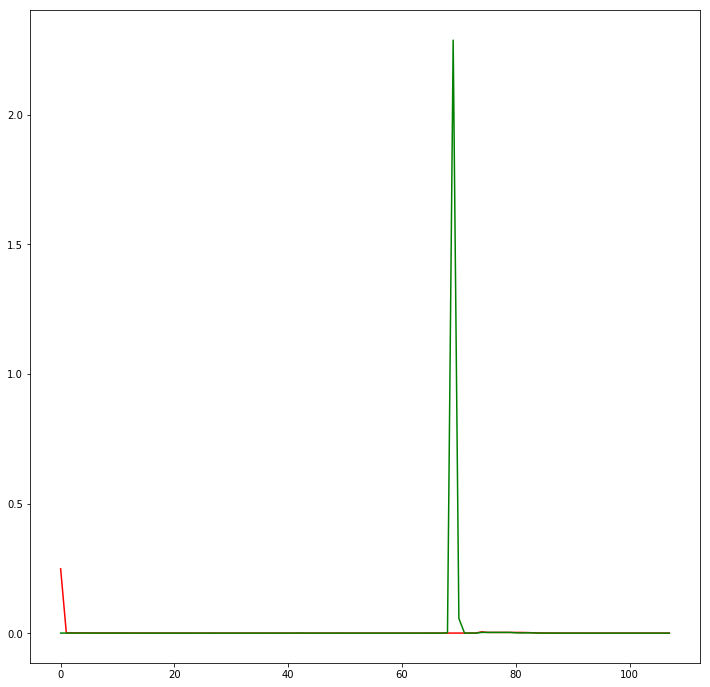

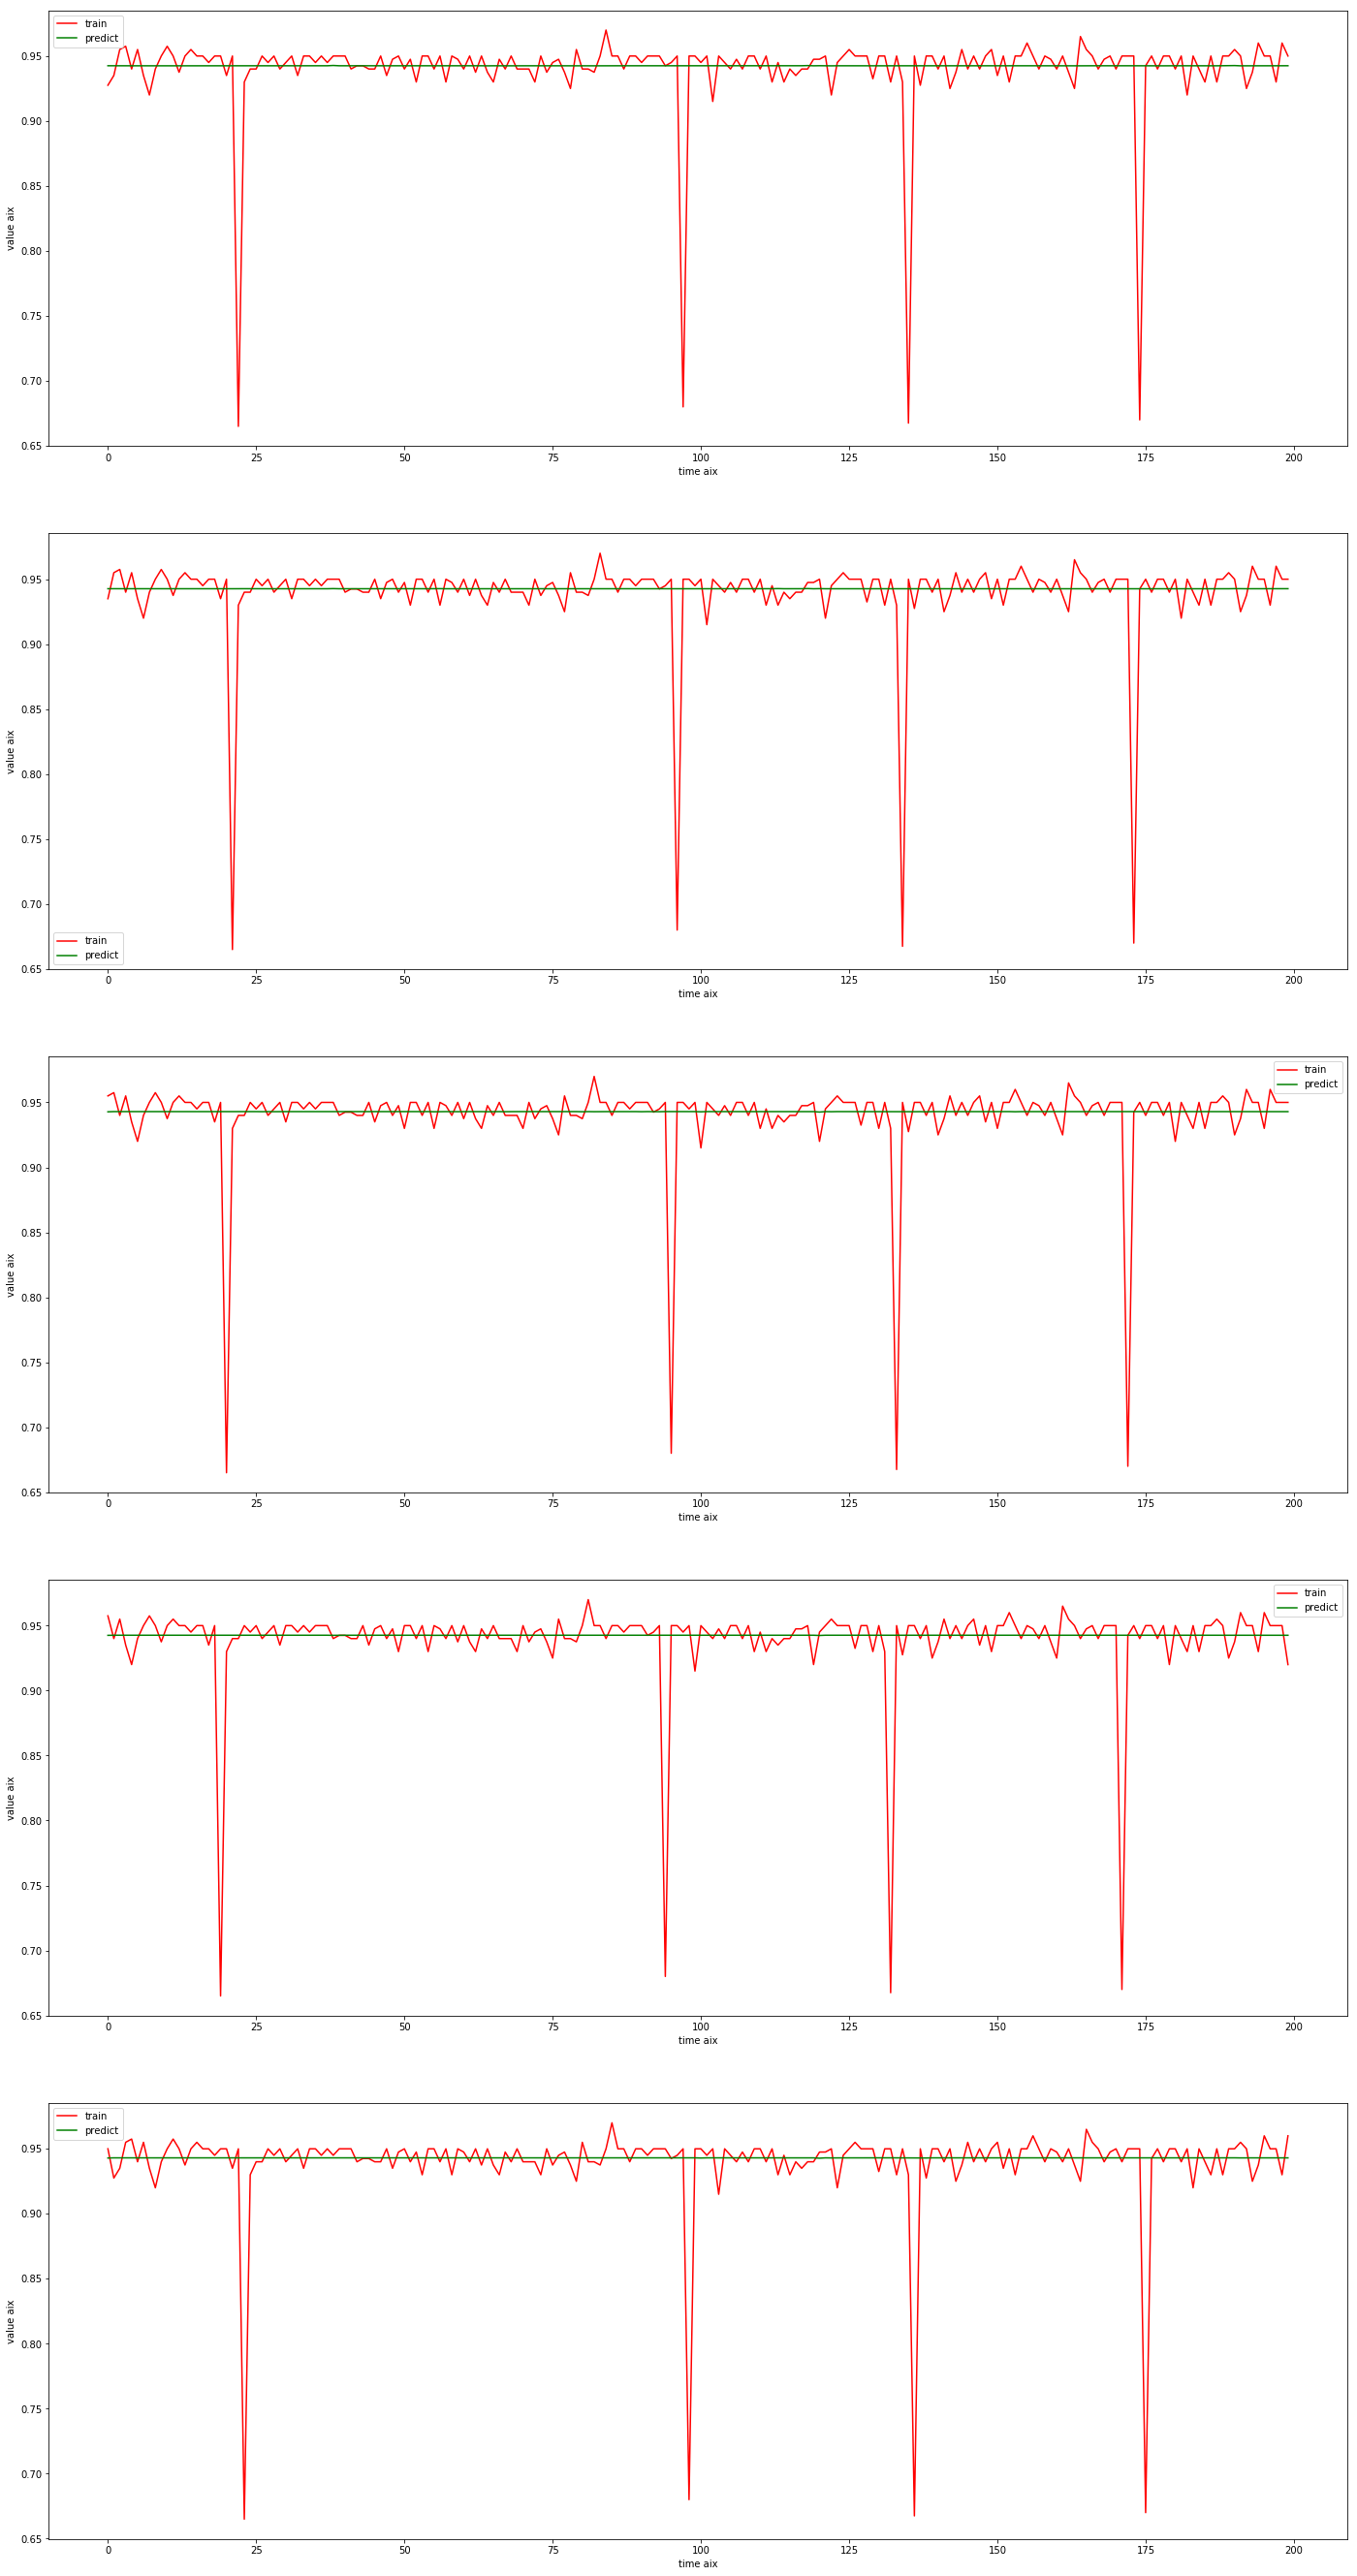

In [5]:
if __name__ == '__main__':
    csvfile = './data/health_179.csv'

    x,y = load_data(csvfile)
    x_,y_ = transform_data(x,y,False)
    datax,datay = format_data(x_,y_)
    trainX,trainY,validX,validY,testX,testY = divide_data(datax,datay)
    
    lstmModel = LstmModel(epoches=446, batch_size=164)
    health_model = lstmModel.create_model()
    save_path = './models/health_{0}.h5'.format(current_time)
    fit_hist = lstmModel.train_model_1(trainX,trainY,validX,validY,save_path)
    #lstmModel.logv("callback train loss{0}".format(losses))
    testPredict = health_model.predict(testX)
    #plot_loss(lstmModel._history.losses,lstmModel._history.val_losses)
    plot_loss(fit_hist.history['loss'],fit_hist.history['val_loss'])
    print (len(fit_hist.history['loss']))
    testPredict = health_model.predict(testX)
    #print ("predict health loss",len(losses))
    #save_path = './models/health_0615.h5'
    #loadModel = load_model(save_path)
    #testPredict = loadModel.predict(testX)
    #print (testY,"-->",testPredict)
    show_plot(testY,testPredict)
    '''

    xy = read_data(csvfile)
    xy_scale = scale_data(xy,is_predict=False,scaler_name='minmax')
    train_x,train_y,test_x,test_y = split_data(xy_scale,threshold=0.8)
    trainX,trainY = recreate_data(train_x,train_y)

    lstmModel = LstmModel(epoches=500, batch_size=32,lr=0.001)
    health_model = lstmModel.create_model()
    save_path = './models/health_{0}.h5'.format(current_time)
    fit_hist = lstmModel.train_model(trainX,trainY,model_save_path=save_path)

    testX,testY = recreate_data(test_x,test_y)
    testPredict = health_model.predict(testX)
    '''
    